# Trabalho #4 - Data pipeline 


Nesse trabalho você vai utilizar um conjunto de dados estruturados para realizar uma tarefa de classificação multiclasse. Para isso, você vai utilizar o  módulo `feature_columns` para criar um pipeline de entrada para a RNA. 

As etapas que você vai realizar para finalizar esse trabalho são as seguintes:

1. Carregar um arquivo CSV usando Pandas;
2. Construir um pipeline de entrada;
3. Transformar as colunas de dados usando o módulo `feature_columns`;
4. Construir, treinar e avaliar uma RNA.

O conjunto de dados utilizado nesse trabalho consiste de uma versão simplificada do conjunto "PetFinder.my Adoption Prediction", que está disponível no Kaggle em https://www.kaggle.com/c/petfinder-adoption-prediction.

## Coloque seu nome aqui:

Nome: Bruno Rodrigues Silva

## Importar principais bibliotecas e funções

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import feature_column
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

## 1. Objetivo do trabalho

As instruções dadas ao longo do enunciado desse trabalho consistem apenas de indicações para facilitar o desenvolvimento do seu trabalho e não precisam ser seguidas exatamente como são fornecidas. 

Você vai verificar que se seguir exatamente as instruções para realizar esse trabalho os resultados obtidos serão insatisfatórios.

O que é esperado de você nesse trabalho é implementar um pipeline de dados e uma RNA que apresenta um desempenho nos resultados de teste melhor do que o obtido simplesmente seguindo as instruções dadas. Assim, você deve tentar realizar modificações no que é sugerido para atingir resultados satisfatórios.

## 2. Conjunto de dados

### 2.1 Descrição dos dados

Existem mais de 11.000 de exemplos (linhas) nesse conjunto de dados, que está na forma de um arquivo tipo CSV. Cada linha descreve um animal de estimação e cada coluna descreve uma característica do animal. Usaremos essas informações para prever a velocidade de adoção de um animal em função de suas características.

A seguir está uma descrição deste conjunto de dados. Observe que existem colunas numéricas e categóricas. Existe também uma coluna de texto livre que não será usada nesse trabalho.

**Entradas:**

- Type - Type of animal (1 = Dog, 2 = Cat)
- Age - Age of pet when listed, in months
- Breed1 - Primary breed of pet (307 valores - Refer to BreedLabels dictionary)
- Gender - Gender of pet (1 = Male, 2 = Female, 3 = Mixed, if profile represents group of pets)
- Color1 - Color 1 of pet (7 values - Refer to ColorLabels dictionary)
- Color2 - Color 2 of pet (7 values - Refer to ColorLabels dictionary)
- MaturitySize - Size at maturity (1 = Small, 2 = Medium, 3 = Large, 4 = Extra Large, 0 = Not Specified)
- FurLength - Fur length (1 = Short, 2 = Medium, 3 = Long, 0 = Not Specified)
- Vaccinated - Pet has been vaccinated (1 = Yes, 2 = No, 3 = Not Sure)
- Sterilized - Pet has been spayed / neutered (1 = Yes, 2 = No, 3 = Not Sure)
- Health - Health Condition (1 = Healthy, 2 = Minor Injury, 3 = Serious Injury, 0 = Not Specified)
- Fee - Adoption fee (0 = Free)
- Description - Profile write-up for this pet. The primary language used is English, with some in Malay or Chinese
- PhotoAmt - Total uploaded photos for this pet

**Saída:**

- AdoptionSpeed
   - 0 - Pet was adopted on the same day as it was listed.
   - 1 - Pet was adopted between 1 and 7 days (1st week) after being listed.
   - 2 - Pet was adopted between 8 and 30 days (1st month) after being listed.
   - 3 - Pet was adopted between 31 and 90 days (2nd & 3rd month) after being listed.
   - 4 - No adoption after 100 days of being listed. (There are no pets in this dataset that waited between 90 and 100 days).

### 2.2 Carregar dados

Esse conjunto de dados está disponível no TensorFlow Dataset e são carregados de uma URL. Usaremos o Pandas para carregar o arquivo CSV em um DataFrame. Execute a célula abaixo para carregar os dados.

In [2]:
# URL dos dados
dataset_url = 'http://storage.googleapis.com/download.tensorflow.org/data/petfinder-mini.zip'

# Nome do arquivo de dados
csv_file = '/content/petfinder-mini.csv'

# Carrega arquivo de dados
dataframe = pd.read_csv(csv_file)

# Dimensão dos dados
print('Dimensão dos dados:', dataframe.shape)
dataframe

Dimensão dos dados: (11537, 15)


,Type,Age,Breed1,Gender,Color1,Color2,MaturitySize,FurLength,Vaccinated,Sterilized,Health,Fee,Description,PhotoAmt,AdoptionSpeed
0,Cat,3,Tabby,Male,Black,White,Small,Short,No,No,Healthy,100,Nibble is a 3+ month old ball of cuteness. He ...,1,2
1,Cat,1,Domestic Medium Hair,Male,Black,Brown,Medium,Medium,Not Sure,Not Sure,Healthy,0,I just found it alone yesterday near my apartm...,2,0
2,Dog,1,Mixed Breed,Male,Brown,White,Medium,Medium,Yes,No,Healthy,0,Their pregnant mother was dumped by her irresp...,7,3
3,Dog,4,Mixed Breed,Female,Black,Brown,Medium,Short,Yes,No,Healthy,150,"Good guard dog, very alert, active, obedience ...",8,2
4,Dog,1,Mixed Breed,Male,Black,No Color,Medium,Short,No,No,Healthy,0,This handsome yet cute boy is up for adoption....,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11532,Dog,24,Poodle,Male,Brown,Golden,Medium,Medium,Not Sure,No,Healthy,0,been at my place for a while..am hoping to fin...,0,4
11533,Cat,1,Domestic Short Hair,Female,Cream,Gray,Medium,Short,No,No,Healthy,0,1 month old white + grey kitten for adoption n...,1,3
11534,Dog,6,Schnauzer,Female,Black,White,Small,Long,Yes,No,Healthy,0,ooooo,1,0
11535,Cat,9,Domestic Short Hair,Female,Yellow,White,Small,Short,Yes,Yes,Healthy,0,she is very shy..adventures and independent..s...,3,4


- Observe que os dados consitem de 11.537 exemplos (linhas) e 15 características (colunas).

## 3. Pré-processamento dos dados

Antes de criar o pipeline de entrada dados, devemos verificar se as classes são balanceadas, remover a coluna de texto ("Description") que não vamos utilizar e dividir os dados nos conjuntos de treinamento, validação e teste.


### 3.1 Analisar saídas

Para verificar se as saídas são balanceadas temos que contar o número de exemplos de cada classe. Execute a célula abaixo para realizar essa contagem.

In [3]:
print('Classes existentes nas saídas:', dataframe.AdoptionSpeed.unique())
print('Número de exemplos de cada classe:\n', dataframe.AdoptionSpeed.value_counts())

Classes existentes nas saídas: [2 0 3 1 4]
Número de exemplos de cada classe:
 2    3153
4    3080
3    2543
1    2432
0     329
Name: AdoptionSpeed, dtype: int64


### Exercício #1: 

O número de exemplos da classe 0 é muito pequeno em relação às outras classes, assim, vamos unir os exemplos da classe 0 com os da classe 1. Fazendo isso, teremos as seguintes saídas possíveis:

    0 - Animal foi adotado entre o dia em que foi listado e 7 dias (1ª semana) após ser listado.
    1 - Animal foi adotado entre 8 e 30 dias (1º mês) após ser listado.
    2 - O animal foi adotado entre 31 e 90 dias (2º e 3º mês) após ser listado.
    3 - Sem adoção após 100 dias de listagem.

Na célula abaixo modifique a coluna "AdoptionSpeed" do DataFrame de forma a alterar os índices das classes de acordo com o definido acima. Para isso use o método `replace` do Pandas com o argumento `inplace-=True`.

In [4]:
# Para você fazer: Alterar classes

new_classes = {
    0:0,
    1:0,
    2:1,
    3:2,
    4:3
}

# Modifique a coluna AdoptionSpeed
dataframe.AdoptionSpeed.replace(new_classes, inplace=True)

# Mostra novas classes e contagem de exemplos de cada classe
print('Classes existentes nas saídas:', dataframe.AdoptionSpeed.unique())
print('Número de exemplos de cada classe:\n', dataframe.AdoptionSpeed.value_counts())

Classes existentes nas saídas: [1 0 2 3]
Número de exemplos de cada classe:
 1    3153
3    3080
0    2761
2    2543
Name: AdoptionSpeed, dtype: int64


**Saída esperada:**

    Classes existentes nas saídas: [1 0 2 3]
    Número de exemplos de cada classe:
    1    3153
    3    3080
    0    2761
    2    2543
    Name: AdoptionSpeed, dtype: int64

- Observe que agora o número de exemplos das classes está mais balanceado.

### Exercício #2: Remover coluna de texto e dividir dados 

Na célula abaixo crie um código que realiza duas operações:

1. Remoção da coluna "Description"
2. Divisão do conjunto de dados em treinamento, validação e teste.

Nessa divisão usaremos 70% dos dados para treinamento, 15% para validação e 15% para teste.

In [5]:
# Para você fazer: 

# Remoção da coluna "Description
dataframe = dataframe.drop(columns="Description")

# Divisão dos dados
train, test = train_test_split(dataframe, train_size=.70, random_state=42)
val, test = train_test_split(test, train_size=.5, random_state=42)


print('Numéro de exemplos de treinamento:', len(train))
print('Numéro de exemplos de validação:', len(val))
print('Numéro de exemplos de teste:', len(test))

Numéro de exemplos de treinamento: 8075
Numéro de exemplos de validação: 1731
Numéro de exemplos de teste: 1731


**Saída esperada:**

    Numéro de exemplos de treinamento: 8075
    Numéro de exemplos de validação: 1731
    Numéro de exemplos de teste: 1731

Execute a célula abaixo para calcular as estatísticas dos dados numéricos.

In [6]:
dataframe.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Age,11537.0,11.743434,19.324221,0.0,2.0,4.0,12.0,255.0
Fee,11537.0,23.957268,80.024226,0.0,0.0,0.0,0.0,2000.0
PhotoAmt,11537.0,3.610211,3.145872,0.0,2.0,3.0,5.0,30.0
AdoptionSpeed,11537.0,1.515039,1.123589,0.0,1.0,1.0,3.0,3.0


## 4. Criar pipeline de entrada de dados

Para criar um pipeline de entradas de dados usando as ferramentas do tensorFlow deve-se realizar as seguintes etapas:

1. Criar objeto dataset
2. Aplicar transformações desejadas nas colunas de dados
3. Escolher quais colunas serão usadas como entrada da RNA


### 4.1 Criar objetos dataset

Para utilizar o módulo `feature_columns` para transformar os dados de entrada enquanto são carregados na RNA durante o treinamento, eles devem estar em um objeto dataset do TensorFlow. 


### Exercício #3: Criar dataset para pipeline de entrada

Na célula abaixo crie uma função que realiza as seguintes operações:

1. Copia dataframe para um novo dataframe sem vínculo com o anterior usando o método copy()
2. Separa a coluna de saídas do dataframe
3. Cria dataset com método `tf.data.Dataset.from_tensor_slices()` usando as entradas e as saídas do DataFrame copiad
4. Embaralha dados se for desejado

Após criar essa função crie os datasets com os dados de treinamento, validação e teste. Use `shuffle=True` para os dados de treinamento e `shuffle=False` para os dados de validação e teste.

In [7]:
# Cria função que calcula número de NaNs em uma coluna
def num_missing(x):
    return sum(x.isnull())

# Aplica função num_missing em todas as colunas
print("Valores ausentes por coluna")
print(val.apply(num_missing, axis=0))

Valores ausentes por coluna
Type             0
Age              0
Breed1           0
Gender           0
Color1           0
Color2           0
MaturitySize     0
FurLength        0
Vaccinated       0
Sterilized       0
Health           0
Fee              0
PhotoAmt         0
AdoptionSpeed    0
dtype: int64


In [8]:
# Para você fazer: Função para criar objeto dataset do TensorFlow

# Define função usando o método tf.data.Dataset.from_tensor_slices
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
    # Copia dataframe sem vínculo com o anterior usando método copy()
    x = dataframe.copy()
    
    # Separa saídas do dataframe
    y = x.pop('AdoptionSpeed')
    
    # Cria dataset com método tf.data.Dataset.from_tensor_slices usando o DataFrame com as entradas e as saídas
    ds = tf.data.Dataset.from_tensor_slices((dict(x), y.values))
    # verifica se deve embaralhar dados
    if shuffle:
        ds = ds.shuffle(len(x))
    
    # Cria lote de dados usando variável batch_size
    ds = ds.batch(batch_size)
    
    # Retorna dataset
    return ds

# Define o tamanho do lote de exemplos
batch_size = 32

# Cria dataset de treinamento, validação e teste, para isso use:
# shuffle=True para os dados de treinamento e shuffle=Flase para os dados de validação e teste
train_ds = df_to_dataset(train, True, batch_size)
val_ds = df_to_dataset(val, False, batch_size)
test_ds = df_to_dataset(test, False, batch_size)

Execute a célula abaixo para criar um lote de dados e verificar se o seu código está correto. Note que somente os 5 primeiros exemplos são mostrados.

In [9]:
for feature_batch, label_batch in train_ds.take(1):
    print('Lista das características:', list(feature_batch.keys()))
    print('Um lote de tipo:', format(feature_batch['Type'][:5]))
    print('Um lote de idade:', format(feature_batch['Age'][:5]))
    print('Um lote de Breed1:', format(feature_batch['Breed1'][:5]))
    print('Um lote de Gender:', format(feature_batch['Gender'][:5]))
    print('Um lote de Color1:', format(feature_batch['Color1'][:5]))
    print('Um lote de Color2:', format(feature_batch['Color2'][:5]))
    print('Um lote de MaturitySize:', format(feature_batch['MaturitySize'][:5]))
    print('Um lote de FurLength:', format(feature_batch['FurLength'][:5]))  
    print('Um lote de Vaccinated:', format(feature_batch['Vaccinated'][:5]))   
    print('Um lote de Sterilized:', format(feature_batch['Sterilized'][:5]))
    print('Um lote de Health:', format(feature_batch['Health'][:5]))
    print('Um lote de Fee:', format(feature_batch['Fee'][:5]))  
    print('Um lote de PhotoAmt:', format(feature_batch['PhotoAmt'][:5]))   
    print('Um lote de saída:', format(label_batch[:5]))

Lista das características: ['Type', 'Age', 'Breed1', 'Gender', 'Color1', 'Color2', 'MaturitySize', 'FurLength', 'Vaccinated', 'Sterilized', 'Health', 'Fee', 'PhotoAmt']
Um lote de tipo: [b'Cat' b'Dog' b'Dog' b'Cat' b'Cat']
Um lote de idade: [2 1 6 1 1]
Um lote de Breed1: [b'Domestic Short Hair' b'Mixed Breed' b'Mixed Breed'
 b'Domestic Short Hair' b'Collie']
Um lote de Gender: [b'Female' b'Male' b'Female' b'Male' b'Female']
Um lote de Color1: [b'Black' b'Black' b'Black' b'Black' b'Brown']
Um lote de Color2: [b'Cream' b'White' b'Brown' b'Gray' b'No Color']
Um lote de MaturitySize: [b'Small' b'Medium' b'Small' b'Medium' b'Small']
Um lote de FurLength: [b'Short' b'Short' b'Short' b'Short' b'Short']
Um lote de Vaccinated: [b'No' b'No' b'Yes' b'No' b'No']
Um lote de Sterilized: [b'No' b'No' b'No' b'No' b'No']
Um lote de Health: [b'Healthy' b'Healthy' b'Healthy' b'Healthy' b'Healthy']
Um lote de Fee: [50  0  0  0  0]
Um lote de PhotoAmt: [3 2 2 2 3]
Um lote de saída: [2 1 3 0 0]


**Saída desejada:**

    Lista das características: ['Type', 'Age', 'Breed1', 'Gender', 'Color1', 'Color2', 'MaturitySize', 'FurLength', 'Vaccinated', 'Sterilized', 'Health', 'Fee', 'PhotoAmt']
    Um lote de idade: [ 1  3 36  4 36]
    Um lote de Breed1: [b'Mixed Breed' b'Rottweiler' b'Mixed Breed' b'Mixed Breed' b'Mixed Breed']
    Um lote de Gender: [b'Female' b'Male' b'Male' b'Female' b'Male']
    Um lote de Color1: [b'Black' b'Black' b'Brown' b'Brown' b'Brown']
    Um lote de Color2: [b'No Color' b'Yellow' b'No Color' b'No Color' b'No Color']
    Um lote de MaturitySize: [b'Medium' b'Medium' b'Medium' b'Medium' b'Medium']
    Um lote de FurLength: [b'Long' b'Medium' b'Medium' b'Medium' b'Short']
    Um lote de Vaccinated: [b'Yes' b'Yes' b'Not Sure' b'No' b'Yes']
    Um lote de Sterilized: [b'No' b'No' b'Yes' b'No' b'Yes']
    Um lote de Health: [b'Healthy' b'Healthy' b'Minor Injury' b'Healthy' b'Minor Injury']
    Um lote de Fee: [0 0 0 0 0]
    Um lote de PhotoAmt: [3 4 1 3 2]
    Um lote de saída: [3 3 4 4 4]

- Pode-se ver que o dataset retorna um dicionário de nomes das colunas de dados e um lote de cada característica.

- Observa-se que nesse conjunto de dados a maioria das caracteríticas são do tipo categóricas.

### 4.2 Função auxílar para verificar os resultados

Para verificar se as transfromações que estamos implementando estão corretas temos que criar uma função para isso, como visto em aula.

Execute a célula abaixo para criar um lote para ser usado como exemplo e criar a função para visualizar o resultado de uma transformação. Note que somente os 5 primeiros exemplos do lote serão mostrados.

In [10]:
# Lote para ser usado como exemplo
example_batch = next(iter(train_ds))[0]

# Função auxiliar para visualizar resulatdos de transfromações
def demo(feature_column):
    feature_layer = layers.DenseFeatures(feature_column)
    print(feature_layer(example_batch).numpy()[:5])

### 4.3 Transformação e inclusão das colunas

Para os dados poderem ser usados por uma RNA eles devem ser transformados. 

Após definir cada uma das transformações temos que incluir as colunas que serão usadas pela RNA em uma lista.

Execute a célula abaixo para inciar a lista de colunas que serão usadas pela RNA e o numéro de entradas total de cada exemplo, que é a soma das entradas de cada dado transformado.

In [11]:
# Incializa lista de características desejadas
columns_list = []

# Inicializa número de entradas de cada exemplo
num_input = 0

### 4.4 Transformação das colunas "Age" e "PhotoAmt"
 
A coluna "Age" representa a idade dos animais em meses. Essa coluna é de dados numéricos, que variam de 0 a 255 meses. 

A coluna "PhotoAmt" representa o número de fotos de cada animal. Essa coluna é de dados numéricos, que variam de 0 a 30.

Tanto a idade como o número de fotos exatos de um animal não são muito importantes. Dessa forma, para utilizar essas duas colunas vamos segmentá-las em intervalos.

Para a idade vamos utilizar em 6 intervalos:

    idade < 3
    3 <= idade < 6
    6 <= idade < 12
    12 <= idade < 60
    60 <= idade < 120
    idade >= 120
    
Para o número de fotos vamos utilizar 4 intervalos:

    fotos < 1
    1 <= fotos < 3
    3 <= fotos < 5
    fotos >= 5


### Exercício #4: Segmentação das colunas "Age" e "PhotoAmt"

Para segmentar uma coluna numérica usando o módulo `feature_column`, é necessário primeiramente definir a coluna como sendo numérica usando o método `feature_column.numeric_column`, para depois segmentá-la usando o método `feature_column.bucketized_column`. 

Na célula abaixo crie um código que segmenta a coluna "Age" nos 6 intervalos definidos acima.

In [12]:
# Para você fazer: Segmentação da coluna Age

# Define coluna como sendo de dados numéricos
age = feature_column.numeric_column("Age")

# Segmenta coluna
animal_age_segs = feature_column.bucketized_column(age, [3, 6, 12, 60, 120])

# Mostra resultado
demo(animal_age_segs)

# Inclui coluna na lista de características desejadas
columns_list.append(animal_age_segs)

# Atualiza número de entradas
num_input += 6

[[0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]]


**Saída esperada:** 

    [[1. 0. 0. 0. 0. 0.]
     [0. 1. 0. 0. 0. 0.]
     [0. 0. 0. 1. 0. 0.]
     [0. 1. 0. 0. 0. 0.]
     [0. 0. 0. 1. 0. 0.]]

Na célula abaixo crie um código que segmenta a coluna "PhotoAmt" nos 4 intervalos definidos acima.

In [13]:
# Para você fazer: Segmentação da coluna PhotoAmt

# Define coluna como sendo de dados numéricos
photo_amg = feature_column.numeric_column("PhotoAmt")

# Segmenat coluna
animal_photo_segs = feature_column.bucketized_column(photo_amg, [1, 3, 5])

# Mostra resultado
demo(animal_photo_segs)

# Inclui coluna na lista de características desejadas
columns_list.append(animal_photo_segs)

# Atualiza número de entradas
num_input += 4

[[0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]]


**Saída esperada:** 

    [[0. 0. 1. 0.]
     [0. 0. 0. 1.]
     [0. 0. 0. 1.]
     [0. 1. 0. 0.]
     [0. 0. 1. 0.]]

### 4.5 Transformação da coluna "Fee"

A coluna "Fee" representa a taxa paga para adotar um determinado animal. Essa coluna é de dados numéricos, sendo que seus valores de variam de 0 a 2000. Para poder ser usado pela RNA esses dados devem ser normalizados. A normalização que iremos utilizar para essa  coluna é transformar os dados para valores reais no intervalo de 0 a 1.

### Exercício #5: Normalização da coluna "Fee"

Para normalizar a coluna "Fee", ao transformá-la em uma coluna numérica selecionamos uma função para aplicar a normalização desejada.

Na célula abaixo crie um código para fazer essas operações.

In [14]:
# Para você fazer: Normalização da coluna Fee

# Calcula valor máximo da coluna
max_fee = 2000
print('Fee máxima =', max_fee, '\n')

# Cria função para normalização
def norm_max_fee(x):
    return x/2000
    
# Aplica método tf.feature_column.numeric_column usando função norm_max_fee
animal_fee_norm = feature_column.numeric_column("Fee", normalizer_fn=norm_max_fee)

# Mostra resultado
demo(animal_fee_norm)

# Inclui coluna na lista de características desejadas
columns_list.append(animal_fee_norm)

# Atualiza número de entradas
num_input += 1

Fee máxima = 2000 

[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]


**Saída esperada:**

    Fee máxima = 2000 

    [[0. ]
     [0. ]
     [0. ]
     [0. ]
     [0.1]]

### 4.6 Transformação das colunas de dados categóricos

As colunas de dados categóricos desse conjunto de dados são as seguintes:

1. Type;
2. Color1;
3. Color2;
4. Gender;
5. MaturitySize;
6. Furlength;
7. vaccinated;
8. Sterilized;
9. Health.

### Exercício #6: Transformação das colunas de dados categóricos

Transforme todas essas colunas em dados categóricos e depois em vetores one-hot.

- Para transformar as colunas em dados categóricos use o método `feature_column.categorical_column_with_vocabulary_list`. Para passar a lista de termos pode usar por exemplo, para a coluna "Type" `dataframe.Type.unique()`;


- Para codificar as categorias em vetores one-hot use o método `feature_column.indicator_column`.


In [15]:
# Para você fazer: Coluna Type

# Coluna Type
animal_type_one_hot = feature_column.categorical_column_with_vocabulary_list("Type", train.Type.unique())
animal_type_one_hot = feature_column.indicator_column(animal_type_one_hot)

# Mostra resultado
demo(animal_type_one_hot)

# Inclui coluna na lista de características desejadas
columns_list.append(animal_type_one_hot)

# Atualiza número de entradas
num_input += len(train.Type.unique())

[[1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]]


**saída esperada:**

    [[1. 0.]
     [1. 0.]
     [1. 0.]
     [0. 1.]
     [0. 1.]]

In [16]:
# Para você fazer: Coluna Color1
    
# Coluna Color1
animal_color1_one_hot = feature_column.categorical_column_with_vocabulary_list("Color1", train.Color1.unique())
animal_color1_one_hot = feature_column.indicator_column(animal_color1_one_hot)
# Mostra resultado
demo(animal_color1_one_hot)

# Inclui coluna na lista de características desejadas
columns_list.append(animal_color1_one_hot)

# Atualiza número de entradas
num_input += len(train.Color1.unique())

[[1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]]


**Saída esperada:**

    [[1. 0. 0. 0. 0. 0. 0.]
     [0. 0. 0. 1. 0. 0. 0.]
     [0. 0. 0. 0. 0. 0. 1.]
     [0. 0. 0. 0. 0. 1. 0.]
     [0. 0. 0. 0. 1. 0. 0.]]

In [17]:
# Para você fazer: Coluna Color2
    
# Coluna Color2
animal_color2_one_hot = feature_column.categorical_column_with_vocabulary_list("Color2", train.Color2.unique())
animal_color2_one_hot = feature_column.indicator_column(animal_color2_one_hot)

# Mostra resultado
demo(animal_color2_one_hot)

# Inclui coluna na lista de características desejadas
columns_list.append(animal_color2_one_hot)

# Atualiza número de entradas
num_input += len(train.Color2.unique())

[[0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]]


**Saída esperada:**

    [[1. 0. 0. 0. 0. 0. 0.]
     [1. 0. 0. 0. 0. 0. 0.]
     [1. 0. 0. 0. 0. 0. 0.]
     [0. 0. 1. 0. 0. 0. 0.]
     [0. 0. 1. 0. 0. 0. 0.]]

In [18]:
# Para você fazer: Coluna Gender
    
# Coluna Gender
animal_gender_one_hot = feature_column.categorical_column_with_vocabulary_list("Gender", train.Gender.unique())
animal_gender_one_hot = feature_column.indicator_column(animal_gender_one_hot)

# Mostra resultado
demo(animal_gender_one_hot)

# Inclui coluna na lista de características desejadas
columns_list.append(animal_gender_one_hot)

# Atualiza número de entradas
num_input += len(train.Gender.unique())

[[1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]]


**Saída esperada:**

    [[0. 1.]
     [0. 1.]
     [1. 0.]
     [1. 0.]
     [1. 0.]]

In [19]:
# Para você fazer: Coluna MaturitySize
    
# Coluna MaturitySize
animal_MaturitySize_one_hot = feature_column.categorical_column_with_vocabulary_list("MaturitySize", train.MaturitySize.unique())
animal_MaturitySize_one_hot = feature_column.indicator_column(animal_MaturitySize_one_hot)


# Mostra resultado
demo(animal_MaturitySize_one_hot)

# Inclui coluna na lista de características desejadas
columns_list.append(animal_MaturitySize_one_hot)

# Atualiza número de entradas
num_input += len(train.MaturitySize.unique())

[[0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]]


**Saída esperada:**

    [[0. 1. 0.]
     [1. 0. 0.]
     [0. 0. 1.]
     [0. 1. 0.]
     [0. 0. 1.]]

In [20]:
# Para você fazer: Coluna FurLength
    
# Coluna FurLength
animal_FurLength_one_hot = feature_column.categorical_column_with_vocabulary_list("FurLength", train.FurLength.unique())
animal_FurLength_one_hot = feature_column.indicator_column(animal_FurLength_one_hot)


# Mostra resultado
demo(animal_FurLength_one_hot)

# Inclui coluna na lista de características desejadas
columns_list.append(animal_FurLength_one_hot)

# Atualiza número de entradas
num_input += len(train.FurLength.unique())

[[0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]]


**Saída esperada:**

    [[1. 0. 0.]
     [0. 0. 1.]
     [0. 1. 0.]
     [0. 1. 0.]
     [1. 0. 0.]]

In [21]:
# Para você fazer: Coluna Vaccinated
    
# Coluna Vaccinated
animal_Vaccinated_one_hot = feature_column.categorical_column_with_vocabulary_list("Vaccinated", train.Vaccinated.unique())
animal_Vaccinated_one_hot = feature_column.indicator_column(animal_Vaccinated_one_hot)


# Mostra resultado
demo(animal_Vaccinated_one_hot)

# Inclui coluna na lista de características desejadas
columns_list.append(animal_Vaccinated_one_hot)

# Atualiza número de entradas
num_input += len(train.Vaccinated.unique())

[[1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]


**Saída esperada:**

    [[1. 0. 0.]
     [0. 0. 1.]
     [0. 0. 1.]
     [1. 0. 0.]
     [0. 0. 1.]]

In [22]:
# Para você fazer: Coluna Sterilized
    
# Coluna Sterilized
animal_Sterilized_one_hot = feature_column.categorical_column_with_vocabulary_list("Sterilized", train.Sterilized.unique())
animal_Sterilized_one_hot = feature_column.indicator_column(animal_Sterilized_one_hot)


# Mostra resultados
demo(animal_Sterilized_one_hot)

# Inclui coluna na lista de características desejadas
columns_list.append(animal_Sterilized_one_hot)

# Atualiza número de entradas
num_input += len(train.Sterilized.unique())

[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]


**Saída esperada:**

    [[1. 0. 0.]
     [0. 0. 1.]
     [0. 1. 0.]
     [1. 0. 0.]
     [1. 0. 0.]]

In [23]:
# Para você fazer: Coluna Health
    
# Coluna Health
animal_Health_one_hot = feature_column.categorical_column_with_vocabulary_list("Health", train.Health.unique())
animal_Health_one_hot = feature_column.indicator_column(animal_Health_one_hot)


# Mostra resultados
demo(animal_Health_one_hot)

# Inclui coluna na lista de características desejadas
columns_list.append(animal_Health_one_hot)

# Atualiza número de entradas
num_input += len(train.Health.unique())

[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]


**Saída esperada:**

    [[1. 0. 0.]
     [1. 0. 0.]
     [1. 0. 0.]
     [1. 0. 0.]
     [1. 0. 0.]]

### 4.7 Transformação da coluna "Breed1"

A coluna que fornece a raça ("Breed1") do animal possui 307 termos diferentes. Transformar essa coluna em vetores one-hot criaria colunas com muitos zeros, o que seria inconveniente. Portanto, nesse caso é melhor utilizar a codificação "embedding" para descrever esses 307 termos diferentes que representam as possíveis raças dos animais. 

Ressalta-se que usar uma codificação "embedding" é melhor para representar dados categóricos quando se tem muitas categorias possíveis. 


### Exercício #7: Transformação da coluna "Breed1"

Na célula abaixo crie um código que realiza a codificação "embedding" da  coluna "Breed'". Observa-se que o tamanho dos vetores "embedding" é um parâmetro que deve ser ajustado. Nesse trabalho tentaremos usar vetores com 8 elementos.

Para fazer essa transformação você deve primeiramente transformar os dados em categorias, usando o método `feature_column.categorical_column_with_vocabulary_list`, para depois realizar a codificação "embeding" usando o método `feature_column.embedding_column`. 

In [24]:
# Para você fazer:

# Transformação da coluna Breed1 em categórica
breed1_embedding = feature_column.categorical_column_with_vocabulary_list("Breed1", train.Breed1.unique(), default_value=0)

# Transfromação em vetores "embedding"
breed1_embedding = feature_column.embedding_column(breed1_embedding, dimension=8)

# Mostra resultados
demo(breed1_embedding)

# Inclui coluna na lista de características desejadas
columns_list.append(breed1_embedding)

# Atualiza número de entradas
num_input += 8

[[ 0.65008396  0.10165078 -0.04194978 -0.16093332 -0.30024204 -0.32743454
   0.38346535 -0.13050535]
 [ 0.16742173 -0.33435595 -0.19376221 -0.25814247  0.15738736  0.49176803
   0.08468107  0.08474744]
 [-0.3681982  -0.35226014 -0.42284435  0.13151576 -0.22593229 -0.5163021
   0.07270201  0.00076011]
 [-0.33017245  0.23206145 -0.18064351 -0.6406341   0.14121059 -0.19722371
  -0.32694975 -0.07609592]
 [ 0.65008396  0.10165078 -0.04194978 -0.16093332 -0.30024204 -0.32743454
   0.38346535 -0.13050535]]


**Saída esperada:**

    [[-0.42777395  0.27999237  0.24018171  0.07493864  0.2034157  -0.09776279
       0.18314685  0.04246866]
     [ 0.22655667  0.16137254  0.33353806  0.21287134  0.27651897 -0.16279218
      -0.25303188 -0.33496138]
     [-0.07981153  0.10738403 -0.27436027 -0.1045252   0.11560448 -0.37660906
      -0.13173237 -0.29564175]
     [-0.3764975  -0.2668523  -0.11631445 -0.15872143  0.23671539 -0.12712602
      -0.2112993   0.30894685]
     [-0.25282273  0.52100515  0.03996713 -0.5479238   0.5706844  -0.25294143
       0.5259882  -0.42650932]]
       
- Observe que os valores dos elementos dos vetores "embedding" são aprendidos durante o treinamento do RNA. Esses valores nesse momento são números aleatórios utilizados para incializar os vetores.

### 4.8 Verificação da lista de colunas

Execute a célula abaixo para verificar se a lista de características usadas pela RNA está correta e o número de entradas de cada exemplo.

In [25]:
len(columns_list)

13

In [26]:
print('Número de entradas =', num_input)
print('\nLista de colunas de características:')
for i in range(13):
    print(i+1, '-', columns_list[i])

Número de entradas = 52

Lista de colunas de características:
1 - BucketizedColumn(source_column=NumericColumn(key='Age', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), boundaries=(3, 6, 12, 60, 120))
2 - BucketizedColumn(source_column=NumericColumn(key='PhotoAmt', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), boundaries=(1, 3, 5))
3 - NumericColumn(key='Fee', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function norm_max_fee at 0x7f4ac0329440>)
4 - IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='Type', vocabulary_list=('Cat', 'Dog'), dtype=tf.string, default_value=-1, num_oov_buckets=0))
5 - IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='Color1', vocabulary_list=('Golden', 'Black', 'Brown', 'White', 'Yellow', 'Cream', 'Gray'), dtype=tf.string, default_value=-1, num_oov_buckets=0))
6 - IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='Color2', voca

**Saída esperada:**

    Número de entradas = 52

    Lista de colunas de características:
    1 - BucketizedColumn(source_column=NumericColumn(key='Age', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), boundaries=(3, 6, 12, 60, 120)) 
    2 - BucketizedColumn(source_column=NumericColumn(key='PhotoAmt', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), boundaries=(1, 3, 5)) 
    .
    .
    .
    12 - IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='Health', vocabulary_list=('Healthy', 'Minor Injury', 'Serious Injury'), dtype=tf.string, default_value=-1, num_oov_buckets=0)) 
    13 - EmbeddingColumn(categorical_column=VocabularyListCategoricalColumn(key='Breed1', vocabulary_list=('Tabby', 'Domestic Medium Hair', 'Mixed Breed', 'Domestic Short Hair', 'Domestic Long Hair', 'Terrier', 'Persian', 'Rottweiler', 'Jack Russell Terrie ... 

## 5. Criar e compilar a RNA

Após definir as tranformações desejadas nos dados, vamos criar a RNA para realizar a tarefa de classificação multiclasse para prever a velocidade de adoção dos animais.


### Exercício #8: Configurar RNA

Para configurar a RNA, a primeira etapa é definir uma camada tipo `DenseFeatures` para inserir as colunas de características selecionadas na variável `columns_list`.

A RNA que iremos usar incicialmente tem a seguinte arquitetura:

1. Uma camada tipo `DenseFeatures`;
2. Uma camada intermediária tipo `Dense`, com 128 neurônios e função de ativação ReLu;
3. Uma camada intermediária tipo `Dense`, com 128 neurônios e função de ativação ReLu;
4. Uma camada de saída tipo `Dense`, com 5 neurônios e função de ativação softmax.

Observe que temos 4 classes de velocidade de adoção, cujos índices variam de 0 a 3.

Realize essas operações na célula abaixo.

In [27]:
# Para você fazer: Configurar a RNA

# Cria camada DenseFeatures
feature_layer = tf.keras.layers.DenseFeatures(columns_list, )

# Configura RNA
rna = tf.keras.models.Sequential()
rna.add(feature_layer)
rna.add(tf.keras.layers.Dense(128, activation='relu'))
rna.add(tf.keras.layers.Dense(128, activation='relu'))
rna.add(tf.keras.layers.Dense(5, activation='softmax'))

# Sumário da rede
rna.summary

<bound method Model.summary of <tensorflow.python.keras.engine.sequential.Sequential object at 0x7f4ac02d7ed0>>

**Saída esperada:**

    <bound method Model.summary of <tensorflow.python.keras.engine.sequential.Sequential object at 0x00000200A691F9C8>>

### Exercício #9: Compilar RNA

Para treinar a RNA tente usar inicialmente os seguintes parâmetros:

- Otimizador: SGD
- Taxa de aprendizado: 0.01
- Função de custo: SparseCategoricalCrossentropy
- Métrica: Accuracy

Na célula abaixo compile a sua RNA com esses parâmetros.

In [28]:
# Para você fazer: Compilar RNA
opt = tf.keras.optimizers.SGD(0.01)

# Compila RNA
rna.compile(opt, loss='sparse_categorical_crossentropy', metrics='accuracy')

## 6. Treinar e avaliar a RNA

### Exercício #10: Treinar a RNA

Na célula abaixo treine a sua RNA usando 50 épocas. Use os dados de validação para verificar se está ocorrendo problemas de overfitting.

In [29]:
# Para você fazer: 

# Treinar a RNA
results = rna.fit(train_ds, epochs=50, validation_data=val_ds)


Epoch 1/50
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
253/253 [==============================] - ETA: 0s - loss: 1.5029 - accuracy: 0.2708WARNING:tensorflow:Layers in a Sequential model should only have a single input tensor, but we receive a <class 'dict'> input: {'Type': <tf.Tensor 'ExpandDims_11:0' shape=(None, 1) dtype=string>, 'Age': <tf.Tensor 'ExpandDims:0' shape=(None, 1) dtype=int64>, 'Breed1': <tf.Tensor 'ExpandDims_1:0' shape=(None, 1) dtype=string>, 'Gender': <tf.Tensor 'ExpandDims_6:0' shape=(None, 1) dtype=string>, 'Color1': <tf.Tensor 'ExpandDims_2:0' shape=(None, 1) dtype=string>, 'Color2': <tf.Tensor 'ExpandDims_3:0' shape=(None, 1) dtype=string>, 'MaturitySize': <tf.Tensor 'ExpandDims_8:0' shape=(None, 1) dtype=string>, 'FurLength': <tf.Tensor 'ExpandDims_5:0' shape=(None, 1) dtype=string>, 'Vaccinated': <tf.Tensor 'ExpandDims_12:0' shape=(None, 1) dtype=string>, 'Sterilized': <tf.Tensor 'ExpandDims_10

**Saída esperada:**

    Epoch 50/50
    253/253 [==============================] - 1s 4ms/step - loss: 0.5468 - accuracy: 0.7777 - val_loss: 2.4025 - val_accuracy: 0.3403

Execute a célula abaixo para verificar como foi o processo de treinamento da sua RNA.

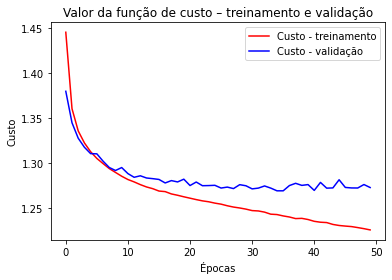

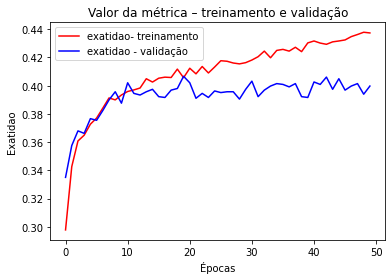

In [30]:
# Recupera resultados de treinamento do dicinário history
acc      = results.history['accuracy']
val_acc  = results.history['val_accuracy']
loss     = results.history['loss']
val_loss = results.history['val_loss']

# Cria vetor de épocas
epocas   = range(len(acc)) 

# Gráfico dos valores da função de custo
plt.plot(epocas, loss, 'r', label='Custo - treinamento')
plt.plot(epocas, val_loss, 'b', label='Custo - validação')
plt.title('Valor da função de custo – treinamento e validação')
plt.xlabel('Épocas')
plt.ylabel('Custo')
plt.legend()
plt.show()

# Gráfico dos valores da métrica
plt.plot(epocas, acc, 'r', label='exatidao- treinamento')
plt.plot(epocas, val_acc, 'b', label='exatidao - validação')
plt.title('Valor da métrica – treinamento e validação')
plt.xlabel('Épocas')
plt.ylabel('Exatidao')
plt.legend()
plt.show()

### Exercício #11: Avaliação da RNA

Calcule o valor da função de custo e da métrica para os dados de teste.

In [31]:
# Para você fazer: Avaliar a RNA para os dados de teste

rna.evaluate(test_ds)

55/55 [==============================] - 0s 5ms/step - loss: 1.2740 - accuracy: 0.4038


[1.2739845514297485, 0.40381282567977905]

**Saída esperada:**

    55/55 [==============================] - 0s 2ms/step - loss: 2.3789 - accuracy: 0.3333

### Exercício #12: Teste da RNA para alguns exemplos de teste

Na célula abaixo gere um lote de dados de teste, calcule a previsão da RNA para esses dados, determine as classes a partir das previsões da RNA e faça um gráfico dos resultados.

Consider rewriting this model with the Functional API.


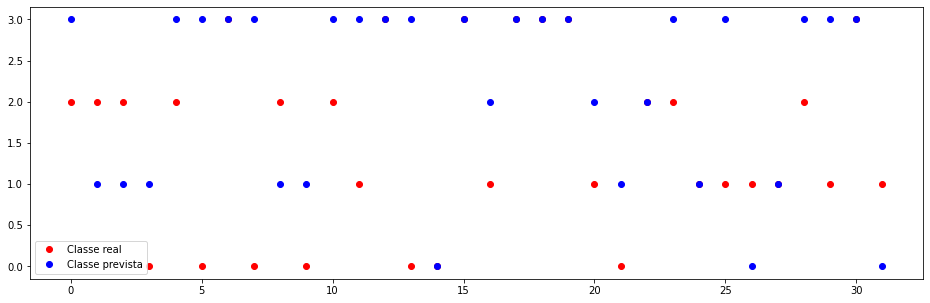

In [32]:
# Para você fazer:

# Gera um lote de exemplos de dados do conjunto de teste
for x, y in test_ds.take(1):
    # calcula previsão da RNA
    y_prev = rna.predict(x)
    
    # Identifica classes dos exemplos
    y_prev = np.argmax(rna.predict(x), axis=1)
    
    # Mostra saídas real e prevista
    plt.figure(figsize=(16,5))
    plt.plot(y, 'ro', label='Classe real')
    plt.plot(y_prev, 'bo', label='Classe prevista')
    plt.legend()
    plt.show()

- Observe que cada círculo vermelho que aparece na figura representa um erro de classificação.

## 7. Para você fazer

Como você deve ter percebido os resultados apresentam muito overfitting e são muito insatisfatórios.

Pense no que você pode fazer para melhorar os dados. Algumas dicas:

1. Usar transformações diferentes nos dados de entrada, tais como, usar intervalos de segmentação diferentes, normalizar valores numéricos de outra forma, agrupar classes de dados categóricos, usar outras características etc.

2. Tentar usar regularização L1, L2 e/ou dropout.

3. Alterar a configuração da RNA, tal como, usar menos/mais camadas, usar menos/mais neurônios, usar outra configuração de rede (residual por exemplo) etc.

**Implemente algumas dessas modificações sugeridas no seu trabalho. A sua nota nesse trabalho depende do desempenho que você conseguir obter com a sua RNA nos dados de teste.**

In [35]:
results = {}

params={
    "optimizers":{
        "adam":[0.01],
        "SGD":[0.01]
    },
    "regularization":{
        "L2":[0.1, 0.5],
        "dropout":[0.3, 0.6]
    }
}

def build_model(dense_layers, units, optimizer_type, learning_rate, regularizator_type, regularizator_value):
    if len(units) != dense_layers:
        print("Number of units elements should be equal to number of layers")
    else:    
        rna = Sequential()
        rna.add(feature_layer)

        for l in range(dense_layers):
            if regularizator_type == "L2":
                rna.add(tf.keras.layers.Dense(units[l], kernel_regularizer=tf.keras.regularizers.l2(regularizator_value), activation='relu'))
            elif regularizator_type == "dropout":
                rna.add(tf.keras.layers.Dense(units[l], activation='relu'))
                rna.add(tf.keras.layers.Dropout(regularizator_value))
        rna.add(tf.keras.layers.Dense(5, activation='softmax'))

        if optimizer_type == "adam":
            opt = tf.keras.optimizers.Adam(learning_rate)
        elif optimizer_type == "SGD":
            opt = tf.keras.optimizers.SGD(learning_rate)

        rna.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics="accuracy")

        return rna


In [50]:
a = {}
a["a"] = "b"
a["a"]

'b'

In [44]:
a

{'a': 'b', 'b': 'c'}

In [51]:
results_list = []
i = 0
for optimizer_type in params["optimizers"]:
    for learning_rate in params["optimizers"][optimizer_type]:
        for regularizator_type in params["regularization"]:
            for regularizator_value in params["regularization"][regularizator_type]:
                rna = build_model(4, [100, 100, 100, 50], optimizer_type, learning_rate, regularizator_type, regularizator_value)
                history = rna.fit(train_ds, validation_data=val_ds, epochs=50, verbose=0)
                results = {
                    "test_id":i,
                    "results":{
                        "optimizer":optimizer_type,
                        "learning_rate":learning_rate,
                        "regularizator":regularizator_type,
                        "regularizator_value":regularizator_value,
                        "history":history.history
                    }
                }
                results_list.append(results)
                print(i+1, 'out of 8')
                i += 1

Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
1 out of 8
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
2 out of 8
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
3 out of 8
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
4 out of 8
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
5 out of 8
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
Consider r


Foram feitos alguns testes com diferentes configurações de redes com as funções acima, e a melhor configuração encontrada até o momento foi de 4 camadas ocultas com as 100, 100, 100 e 50 neurônios respectivamente. Os resultados do GridSearch foram armazenados no dicionário ```results``` e serão analisados agora. 

Também poderia ser feito um GridSearch de epochs, mas isso não é necessário nessa demanda, uma vez que podemos analisar o ponto de treino onde ocorre overfitting a partir das curvas Treino x Validação.


In [52]:
def training_plots(history):
    # Recupera resultados de treinamento do dicinário history
    acc      = history['accuracy']
    val_acc  = history['val_accuracy']
    loss     = history['loss']
    val_loss = history['val_loss']

    # Cria vetor de épocas
    epocas   = range(len(acc)) 

    # Gráfico dos valores da função de custo
    plt.plot(epocas, loss, 'r', label='Custo - treinamento')
    plt.plot(epocas, val_loss, 'b', label='Custo - validação')
    plt.title('Valor da função de custo – treinamento e validação')
    plt.xlabel('Épocas')
    plt.ylabel('Custo')
    plt.legend()
    plt.show()

    # Gráfico dos valores da métrica
    plt.plot(epocas, acc, 'r', label='exatidao- treinamento')
    plt.plot(epocas, val_acc, 'b', label='exatidao - validação')
    plt.title('Valor da métrica – treinamento e validação')
    plt.xlabel('Épocas')
    plt.ylabel('Exatidao')
    plt.legend()
    plt.show()

Experiment 0
best iteration: 0.27787405252456665
adam
0.01
L2
0.1


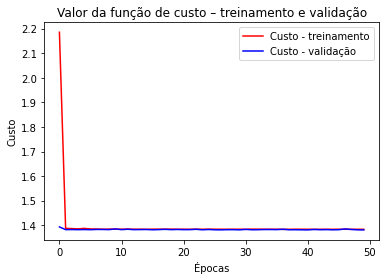

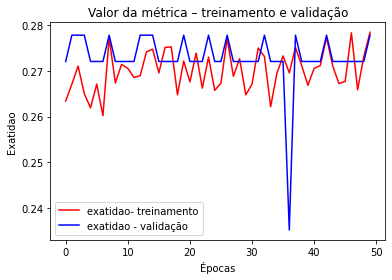

Experiment 1
best iteration: 0.27787405252456665
adam
0.01
L2
0.5


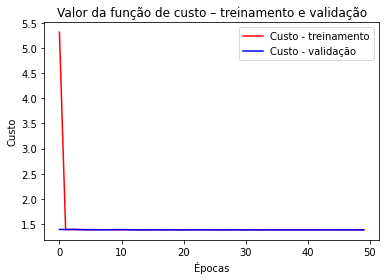

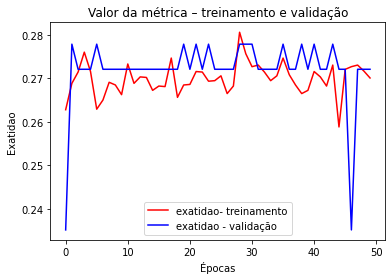

Experiment 2
best iteration: 0.3934141993522644
adam
0.01
dropout
0.3


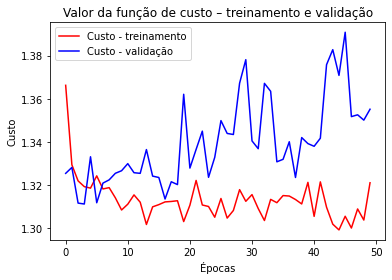

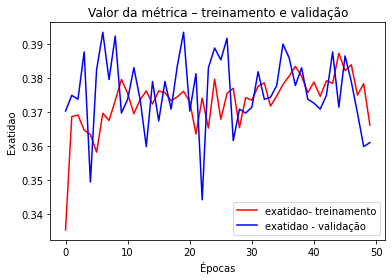

Experiment 3
best iteration: 0.3547082543373108
adam
0.01
dropout
0.6


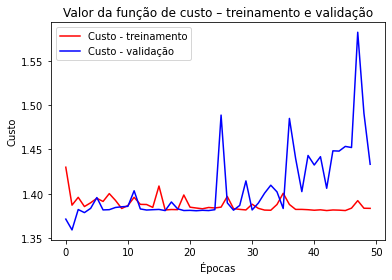

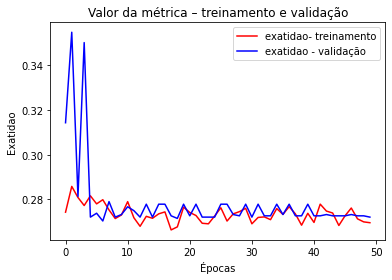

Experiment 4
best iteration: 0.27787405252456665
SGD
0.01
L2
0.1


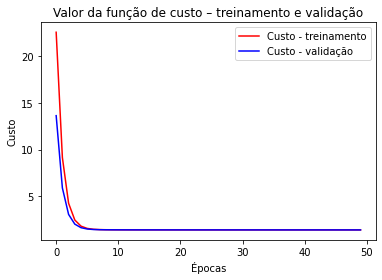

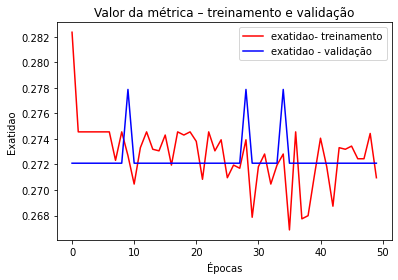

Experiment 5
best iteration: 0.27787405252456665
SGD
0.01
L2
0.5


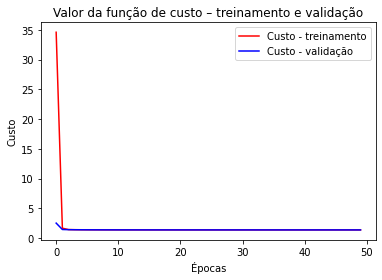

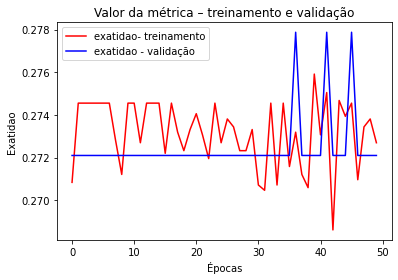

Experiment 6
best iteration: 0.4113229215145111
SGD
0.01
dropout
0.3


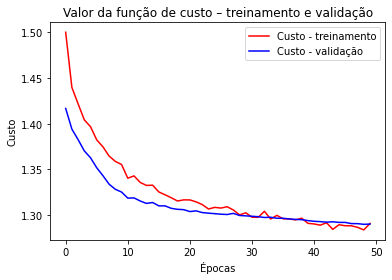

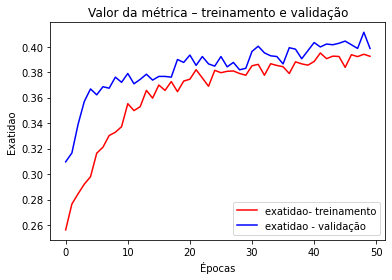

Experiment 7
best iteration: 0.34950894117355347
SGD
0.01
dropout
0.6


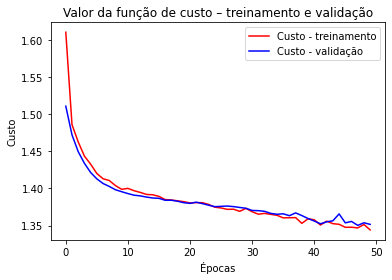

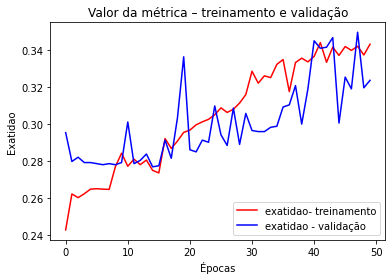

In [62]:
for experiment in results_list:
    print("Experiment", experiment["test_id"])
    print("best iteration:", max(experiment["results"]["history"]["val_accuracy"]))
    for r in experiment["results"]:
        if r == "history":
            training_plots(experiment["results"]["history"])
        else:
            print(experiment["results"][r])


Conforme demonstrado, a melhor iteração teve o resultado:
- accuracy: 0.4113229215145111
- SGD Learning Rate: 0.01
- dropout 0.3
- 50 épocas